<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [219]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [220]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [221]:
# !ls ~/Downloads -la
# !mv ~/Downloads/thumbnails128x128.zip ./

In [222]:
# !unzip -q thumbnails128x128.zip -d flickr_faces/

In [223]:
!ls flickr_faces/thumbnails128x128 | head -n 3

00000
02000
03000


In [224]:
DATA_DIR = 'flickr_faces/thumbnails128x128'

In [225]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision

In [226]:
# dir(torchvision)

In [245]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    apply_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.transforms.Resize(image_size),
        ]
    )
    ds = ImageFolder(DATA_DIR, transform=apply_transform)
    data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    return data_loader

In [275]:
image_size = 128
batch_size = 1
train_loader = get_dataloader(image_size, batch_size)

In [276]:
# for batch in train_loader:
#     print(len(batch))

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [300]:
class MyDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 8, 3), 
            nn.MaxPool2d(2), 
            nn.ReLU(), 
            nn.Conv2d(8, 16, 3), 
            nn.MaxPool2d(2), 
            nn.ReLU(), 
            nn.Conv2d(16, 32, 3),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Conv2d(32, 64, 3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*2*2, 1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [301]:
discriminator = MyDiscriminator()
discriminator = discriminator.to(device)

In [302]:
class MyGenerator(nn.Module):
    def __init__(self, latent_size, image_size):
        super().__init__()
        self.latent_size = latent_size
        self.image_size = image_size

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(self.latent_size, 128, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, output_padding=1),
        )

    def forward(self, x):
        x = self.generator(x)
        return x

In [303]:
latent_size = 100 # choose latent size

generator = MyGenerator(latent_size, image_size)
generator = generator.to(device)

In [304]:
random_noise = torch.randn((16, latent_size, 1, 1))

(array([  7.,   7.,  14.,  23.,  56.,  77., 111., 125., 165., 185., 177.,
        200., 161., 115.,  72.,  57.,  23.,  12.,   9.,   4.]),
 array([-3.07916117, -2.77398443, -2.46880746, -2.16363072, -1.85845375,
        -1.55327702, -1.24810016, -0.94292325, -0.63774645, -0.3325696 ,
        -0.02739275,  0.27778411,  0.58296096,  0.88813776,  1.19331467,
         1.49849153,  1.80366826,  2.10884523,  2.41402197,  2.71919894,
         3.02437568]),
 <BarContainer object of 20 artists>)

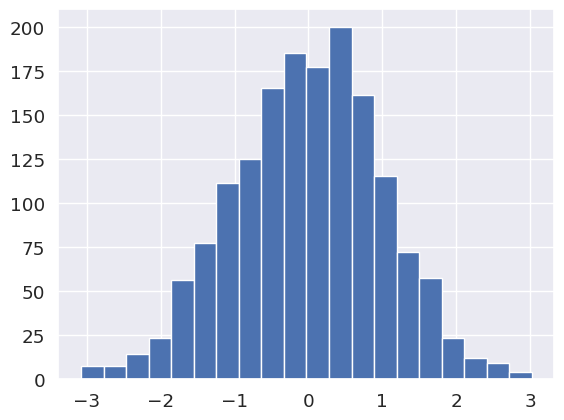

In [305]:
import matplotlib.pyplot as plt
points = []
for i in range(len(random_noise)):
    points_i = random_noise.numpy()[i].squeeze()
    for j in range(len(points_i)):
        points.append(points_i[j])
plt.hist(points, bins=20)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [306]:
discriminator = MyDiscriminator()
discriminator = discriminator.to(device)

generator = MyGenerator(latent_size, image_size)
generator = generator.to(device)

In [307]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [308]:
def fit(model, criterion, loader, epochs, lr):
    optimizer = {
        'discriminator': torch.optim.SGD(model['discriminator'].parameters(), lr=lr, momentum=0.9, nesterov=True)
    }
    model['discriminator'].train()

    
    for epoch in range(epochs):
        for X, _ in loader:
            optimizer['discriminator'].zero_grad()
            batch_size = len(X)
            real_y = torch.ones(batch_size).to(device)
            fake_y = torch.zeros(batch_size).to(device)

            real_images = X.to(device)
            random_noise = torch.randn((batch_size, latent_size, 1, 1)).to(device)
            fake_images = model['generator'](random_noise)
            
            the_batch = torch.concat([real_images, fake_images])
            the_y = torch.concat([real_y, fake_y])

            probs = model['discriminator'](the_batch)
            loss = criterion['discriminator'](the_y, probs)

            print(probs)
            print(the_y)
            print('------------------')
            print(loss)
            
            loss.backward()
            optimizer['discriminator'].step()
            break

In [309]:
fit(model, criterion, train_loader, 1, lr)

ValueError: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])) is deprecated. Please ensure they have the same size.

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [ ]:
def show_images(generated):
  # TODO: show generated images
  pass

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: